In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import v2 as T
import utils
from engine import train_one_epoch, evaluate
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import matplotlib.pyplot as plt
import cv2
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from scipy.optimize import linear_sum_assignment
import numpy as np
import imageio
from tqdm import tqdm
from sklearn.cluster import KMeans


/home/djoser/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)
def normalize_data (data,min_data, max_data):
    return (data-min_data)/(max_data-min_data)

In [3]:
player_detector=torch.load("save_models/player_detector.pt")
ball_detector_1=torch.load("save_models/ball_detector_1.pt")
ball_detector_2=torch.load("save_models/ball_detector_2.pt")
scene_constructor=torch.load("save_models/3D_constructor.pt")
#cor_detector=torch.load("save_models/correspondances_detector.pt")

/tmp/ipykernel_26020/3117666650.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  player_detector=torch.load("save_models/player_detector.pt")
/tmp/ipykernel_26020/3117666

In [4]:
ball_x_save=[]
ball_y_save=[]
players_x_save=[]
players_y_save=[]

In [5]:
min_data=np.array([0,0,0,0])
max_data=np.array([1280,720,1280,720])
print(max_data.shape)
print([4,4,4])
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
prev_ball_pos_1=torch.Tensor(np.array([[952, 194, 993, 234]]))
prev_ball_pos_2=torch.Tensor(np.array([[277, 205, 321, 249]]))



(4,)
[4, 4, 4]


In [6]:
X_train= [
    [861, 191, 420, 208],  # x1, y1, x2, y2
    [525, 290, 292, 176],
    [989, 159, 757, 309],
    [199, 484, 209, 179],  # cages 3m largeur 2m hauteur
    [132, 281, 209, 124],
    [161, 358, 294, 158],
    [122, 213, 290, 111],
    [1068, 158, 1086, 506],
    [1074, 109, 1156, 287],
    [986, 139, 1122, 381],
    [991, 94, 1162, 231],
    [867, 117, 1144, 288],
    [138, 269, 393, 139],
    [1189, 286, 85, 293],
    [632, 150, 637, 166],
    [976,216,289,252],
    [802,115,933,210],
    [1008,151,966,385]

]

# Fonction pour générer des variations des points connus
def generate_variations(point, variation_range=200):
    variations = []
    # x1+
    variation = point.copy()
    variation[0] += np.random.randint(1, variation_range)
    variations.append(variation)
    # x1-
    variation = point.copy()
    variation[0] -= np.random.randint(1, variation_range)
    variations.append(variation)
    # y1+
    variation = point.copy()
    variation[1] += np.random.randint(1, variation_range)
    variations.append(variation)
    # y1-
    variation = point.copy()
    variation[1] -= np.random.randint(1, variation_range)
    variations.append(variation)
    # x2+
    variation = point.copy()
    variation[2] += np.random.randint(1, variation_range)
    variations.append(variation)
    # x2-
    variation = point.copy()
    variation[2] -= np.random.randint(1, variation_range)
    variations.append(variation)
    # y2+
    variation = point.copy()
    variation[3] += np.random.randint(1, variation_range)
    variations.append(variation)
    # y2-
    variation = point.copy()
    variation[3] -= np.random.randint(1, variation_range)
    variations.append(variation)
    return variations

# Générer le dataset d'entraînement
X_data = []
y_data = []
temp_true=5
i=0
for point in X_train:
    X_data.append(point)
    y_data.append([-1])
    if i<temp_true:
        variations = generate_variations(point)
        for variation in variations:
            X_data.append(variation)
            y_data.append([1])
    i+=1

# Convertir les listes en tableaux NumPy
X_data = np.array(X_data)
y_data = np.array(y_data)

# Afficher les données générées
print("X_train:", X_data)
print("y_train:", y_data)
min_data=np.array([0,0,0,0])
max_data=np.array([1280,720,1280,720])

X_data=normalize_data(np.array(X_data),min_data,max_data)
print(X_data)


X_train: [[ 861  191  420  208]
 [ 997  191  420  208]
 [ 669  191  420  208]
 [ 861  296  420  208]
 [ 861   87  420  208]
 [ 861  191  531  208]
 [ 861  191  418  208]
 [ 861  191  420  217]
 [ 861  191  420   97]
 [ 525  290  292  176]
 [ 621  290  292  176]
 [ 519  290  292  176]
 [ 525  472  292  176]
 [ 525  236  292  176]
 [ 525  290  447  176]
 [ 525  290  220  176]
 [ 525  290  292  223]
 [ 525  290  292  136]
 [ 989  159  757  309]
 [1046  159  757  309]
 [ 900  159  757  309]
 [ 989  327  757  309]
 [ 989  -25  757  309]
 [ 989  159  780  309]
 [ 989  159  654  309]
 [ 989  159  757  423]
 [ 989  159  757  267]
 [ 199  484  209  179]
 [ 360  484  209  179]
 [  81  484  209  179]
 [ 199  534  209  179]
 [ 199  342  209  179]
 [ 199  484  307  179]
 [ 199  484   77  179]
 [ 199  484  209  183]
 [ 199  484  209  101]
 [ 132  281  209  124]
 [ 182  281  209  124]
 [ -28  281  209  124]
 [ 132  427  209  124]
 [ 132  185  209  124]
 [ 132  281  342  124]
 [ 132  281  129  124]
 [

In [7]:
import torch.nn as nn

import torch.optim as optim
 
# Define the model
cor_detector = nn.Sequential(
    nn.Linear(4, 128),
    nn.SiLU(),
    nn.Linear(128, 128),
    nn.SiLU(),
    nn.Linear(128, 256),
    nn.SiLU(),
    nn.Linear(256, 256),
    nn.SiLU(),
    nn.Linear(256, 128),
    nn.SiLU(),
    nn.Linear(128, 1),
    #nn.Tanh()
)
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(cor_detector.parameters(), lr=0.0001)

In [8]:
# Déplacer les modèles sur le dispositif
player_detector.to(device)
ball_detector_1.to(device)
ball_detector_2.to(device)
cor_detector.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): SiLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): SiLU()
  (4): Linear(in_features=128, out_features=256, bias=True)
  (5): SiLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): SiLU()
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): SiLU()
  (10): Linear(in_features=128, out_features=1, bias=True)
)

Epoch:0 ---- ACC=0.0
Epoch:1 ---- ACC=0.0
Epoch:2 ---- ACC=0.0
Epoch:3 ---- ACC=0.0
Epoch:4 ---- ACC=0.0
Epoch:5 ---- ACC=0.0
Epoch:6 ---- ACC=0.0
Epoch:7 ---- ACC=0.0
Epoch:8 ---- ACC=0.0
Epoch:9 ---- ACC=0.0
Epoch:10 ---- ACC=0.0
Epoch:11 ---- ACC=0.0
Epoch:12 ---- ACC=0.0
Epoch:13 ---- ACC=0.0
Epoch:14 ---- ACC=0.0
Epoch:15 ---- ACC=0.0
Epoch:16 ---- ACC=0.0
Epoch:17 ---- ACC=0.0
Epoch:18 ---- ACC=0.0
Epoch:19 ---- ACC=0.0
Epoch:20 ---- ACC=0.0
Epoch:21 ---- ACC=0.0
Epoch:22 ---- ACC=0.0
Epoch:23 ---- ACC=0.0
Epoch:24 ---- ACC=0.0
Epoch:25 ---- ACC=0.0
Epoch:26 ---- ACC=0.0
Epoch:27 ---- ACC=0.0
Epoch:28 ---- ACC=0.0
Epoch:29 ---- ACC=0.0
Epoch:30 ---- ACC=0.03448275849223137
Epoch:31 ---- ACC=0.06896551698446274
Epoch:32 ---- ACC=0.10344827175140381
Epoch:33 ---- ACC=0.10344827175140381
Epoch:34 ---- ACC=0.13793103396892548
Epoch:35 ---- ACC=0.1551724076271057
Epoch:36 ---- ACC=0.17241379618644714
Epoch:37 ---- ACC=0.20689654350280762
Epoch:38 ---- ACC=0.22413793206214905
Epoch:39 

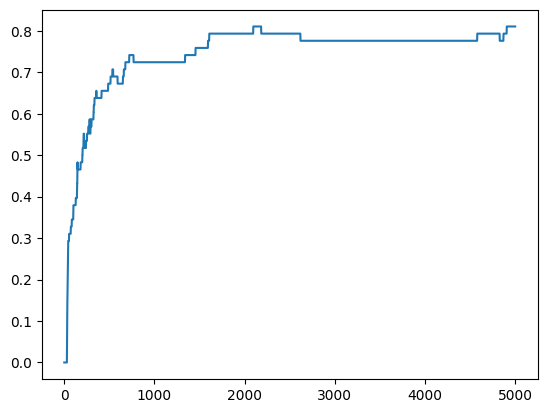

In [9]:
import copy
X_train = torch.tensor(X_data, dtype=torch.float32).to(device)
y_train = torch.tensor(y_data, dtype=torch.float32).to(device)
X_test = torch.tensor(X_data, dtype=torch.float32).to(device)
y_test = torch.tensor(y_data, dtype=torch.float32).to(device)

# training parameters
n_epochs = 5000  # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_acc = -np.inf   # init to negative infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    cor_detector.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = cor_detector(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            acc = (y_pred.round() == y_batch).float().mean()
            bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
            )
    # evaluate accuracy at end of each epoch
    cor_detector.eval()
    y_pred = cor_detector(X_test)
    acc = (y_pred.round() == y_test).float().mean()
    acc = float(acc)

    print(f"Epoch:{epoch} ---- ACC={acc}")

    history.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(cor_detector.state_dict())

# restore model and return best accuracy
cor_detector.load_state_dict(best_weights)

print("ACC: %.2f" % best_acc)
plt.plot(history)
plt.show()

In [10]:
list1=np.array([1,2,3,4])
print(list1[2:])

[3 4]


In [11]:
class Sampler:
    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """Sampler.

        Args:
            model: Neural network to use for modeling E_theta
            img_shape: Shape of the images to model
            sample_size: Batch size of the samples
            max_len: Maximum number of data points to keep in the buffer

        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,) + img_shape) * 2 - 1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=0.1):
        """Function for getting a new batch of "fake" images.

        Args:
            steps: Number of iterations in the MCMC algorithm
            step_size: Learning rate nu in the algorithm above

        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size - n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[: self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model,inp_imgs, pre_data, orientation, steps=100, step_size=0.1, return_img_per_step=False):
        """Function for sampling images for a given model.

        Args:
            model: Neural network to use for modeling E_theta
            inp_imgs: Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps: Number of iterations in the MCMC algorithm.
            step_size: Learning rate nu in the algorithm above
            return_img_per_step: If True, we return the sample at every iteration of the MCMC
        """
        # Définir le dispositif
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        #pre_data=torch.tensor(points).float().to(device)
        
        #pre_data.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        #print(had_gradients_enabled)
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=device)

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        # Convert inputs to tensors and move to device
        #points = torch.tensor(points).float().to(device)
        inp_imgs = torch.tensor(inp_imgs).float().to(device)

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0,0.01)

          

            # Part 2: calculate gradients for the current input.
            if orientation == 0:
                pre_data[2:].data.add_(noise.data)
                #pre_data = torch.cat([pre_data, inp_imgs], dim=0)
            else:
                pre_data[:2].data.add_(noise.data)
                #pre_data = torch.cat([inp_imgs, pre_data], dim=0)

            pre_data.requires_grad = True

            out_imgs = -model(pre_data)
            #print(f"\nres = {out_imgs}\n pos = {pre_data}")
            out_imgs.sum().backward()
            pre_data.grad.data.clamp_(-0.03, 0.03)

            # Print gradients for debugging
            #print("Gradients:", pre_data.grad)

            # Apply gradients to our current samples
            if orientation == 0:
                pre_data[2:].data.add_(-step_size * pre_data.grad.data[:2])
            else:
                pre_data[:2].data.add_(-step_size * pre_data.grad.data[2:])

            pre_data.grad.detach_()
            pre_data.grad.zero_()

            if return_img_per_step:
                imgs_per_step.append(pre_data.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return pre_data

In [13]:

for n in tqdm(range(1, 12000), desc="Processing frames"):
    image1 = read_image(f"data/match1/angle1/frame_{n:08d}.png")
    image2 = read_image(f"data/match1/angle2/frame_{n+55:08d}.png")
    eval_transform = get_transform(train=False)
    player_detector.eval()
    with torch.no_grad():
        x1 = eval_transform(image1)
        # convert RGBA -> RGB and move to device
        x1 = x1[:3, ...].to(device)
        predictions1 = player_detector([x1, ])
        pred1 = predictions1[0]


        x2 = eval_transform(image2)
        # convert RGBA -> RGB and move to device
        x2 = x2[:3, ...].to(device)
        predictions2 = player_detector([x2, ])
        pred2 = predictions2[0]



    image1 = (255.0 * (image1 - image1.min()) / (image1.max() - image1.min())).to(torch.uint8)
    image2 = (255.0 * (image2 - image2.min()) / (image2.max() - image2.min())).to(torch.uint8)
    image1 = image1[:3, ...]
    image2 = image2[:3, ...]
    pred_labels1 = [f"pedestrian: {score:.3f}" for label, score in zip(pred1["labels"], pred1["scores"])]
    pred_labels2 = [f"pedestrian: {score:.3f}" for label, score in zip(pred2["labels"], pred2["scores"])]
    pred_boxes_persons1 = pred1["boxes"].long()
    pred_boxes_persons2 = pred2["boxes"].long()


    masks1 = (pred1["masks"] > 0.7).squeeze(1)
    masks2 = (pred2["masks"] > 0.7).squeeze(1)

    eval_transform = get_transform(train=False)
    ball_detector_1.eval()
    ball_detector_2.eval()
    with torch.no_grad():
        x1 = eval_transform(image1)
        # convert RGBA -> RGB and move to device
        x1 = x1[:3, ...].to(device)
        predictions1 = ball_detector_1([x1, ])
        pred1 = predictions1[0]


        x2 = eval_transform(image2)
        # convert RGBA -> RGB and move to device
        x2 = x2[:3, ...].to(device)
        predictions2 = ball_detector_2([x2, ])
        pred2 = predictions2[0]


    image1 = (255.0 * (image1 - image1.min()) / (image1.max() - image1.min())).to(torch.uint8)
    image2 = (255.0 * (image2 - image2.min()) / (image2.max() - image2.min())).to(torch.uint8)
    image1 = image1[:3, ...]
    image2 = image2[:3, ...]
    pred_labels1 = [f"pedestrian: {score:.3f}" for label, score in zip(pred1["labels"], pred1["scores"])]
    pred_labels2 = [f"pedestrian: {score:.3f}" for label, score in zip(pred2["labels"], pred2["scores"])]
    pred_boxes_ball1 = pred1["boxes"].long()
    pred_boxes_ball2 = pred2["boxes"].long()


    masks1 = (pred1["masks"] > 0.7).squeeze(1)
    masks2 = (pred2["masks"] > 0.7).squeeze(1)
    sampler=Sampler(cor_detector,(2,),1)
    cor_detector.eval()
    #if len(pred_boxes_ball1)== 1 and len(pred_boxes_ball2)==1:
     #   prev_ball_pos_1=pred_boxes_ball1
      #  prev_ball_pos_2=pred_boxes_ball2
    #else :
    #    pred_boxes_ball1=prev_ball_pos_1
    #    pred_boxes_ball2=prev_ball_pos_2
    
    if len(pred_boxes_ball1)!= 1 and len(pred_boxes_ball2)==1:
        noise = torch.randn((2,), device=device)
        noise.normal_(0.5,0)
        np_ball2=pred_boxes_ball2[0].cpu().numpy()
        x_mean = (np_ball2[0]+np_ball2[2])/2
        y_mean = (np_ball2[1]+np_ball2[3])/2
        
        balise= np.array([x_mean,y_mean])
        balise=normalize_data(balise,min_data[2:],max_data[2:])
        tens=torch.tensor(balise).float().to(device)
        pre_data = torch.cat([noise, tens], dim=0)
        
        #print(pre_data)

        estim = sampler.generate_samples(cor_detector,noise,pre_data,1).detach().cpu().numpy()
        estim= (estim+min_data)*max_data

        pred_center1=estim[:2]
        pred_center1 = np.clip(pred_center1, 0, 1)
        pred_boxes_ball1=np.array([[pred_center1[0]+10,pred_center1[1]+10,pred_center1[0]-10,pred_center1[1]-10]])
        pred_boxes_ball1=torch.tensor(pred_boxes_ball1).to(device)
        print( f"estimation from angle 2 : {estim} frame n°{n}")
    if len(pred_boxes_ball1)== 1 and len(pred_boxes_ball2)!=1:
        noise = torch.randn((2,), device=device)
        noise.normal_(0.5,0)
        np_ball1=pred_boxes_ball1[0].cpu().numpy()
        x_mean = (np_ball1[0]+np_ball1[2])/2
        y_mean = (np_ball1[1]+np_ball1[3])/2
        balise= np.array([x_mean,y_mean])
        balise=normalize_data(balise,min_data[:2],max_data[:2])
        tens=torch.tensor(balise).float().to(device)
        pre_data = torch.cat([tens, noise], dim=0).to(device)
        #print(pre_data)

        estim = sampler.generate_samples(cor_detector,noise,pre_data,0).detach().cpu().numpy()
        estim= (estim+min_data)*max_data
        pred_center2=estim[2:]
        pred_center2 = np.clip(pred_center2, 0, 1)

        pred_boxes_ball2=np.array([[pred_center2[0]+10,pred_center2[1]+10,pred_center2[0]-10,pred_center2[1]-10]])
        pred_boxes_ball2=torch.tensor(pred_boxes_ball2).to(device)
        print( f"estimation from angle 1 : {estim} frame n°{n}")
    if len(pred_boxes_ball1)!= 1 and len(pred_boxes_ball2)!=1:
        pred_boxes_ball1=prev_ball_pos_1
        pred_boxes_ball2=prev_ball_pos_2
    prev_ball_pos_1=pred_boxes_ball1
    prev_ball_pos_2=pred_boxes_ball2
    np_ball1=pred_boxes_ball1[0].cpu().numpy()
    np_ball2=pred_boxes_ball2[0].cpu().numpy()


    x_mean_1 = (np_ball1[0]+np_ball1[2])/2
    y_mean_1 = (np_ball1[1]+np_ball1[3])/2
    x_mean_2 = (np_ball2[0]+np_ball2[2])/2
    y_mean_2 = (np_ball2[1]+np_ball2[3])/2

    points1 = np.array([[x_mean_1, y_mean_1]])  # Points 2D dans la vue 1
    points2 = np.array([[x_mean_2, y_mean_2]])
    ball=normalize_data(np.concatenate((points1.flatten(),points2.flatten())),min_data,max_data)
    ball_pos=scene_constructor(torch.from_numpy(ball).float())
    pred_boxes_persons1_np = pred_boxes_persons1.cpu().numpy()
    pred_boxes_persons2_np = pred_boxes_persons2.cpu().numpy()

    # Calculer les centres des bounding boxes
    centers1 = [((box[0] + box[2]) / 2, (box[1] + box[3]) / 2) for box in pred_boxes_persons1_np]
    centers2 = [((box[0] + box[2]) / 2, (box[1] + box[3]) / 2) for box in pred_boxes_persons2_np]

    # Convertir les listes de centres en tableaux NumPy
    centers1_np = np.array(centers1)
    centers2_np = np.array(centers2)
    #print(centers1_np)
    # Initialiser le tableau des scores
    score_matrix = np.zeros((len(centers1_np), len(centers2_np)))

    # Calculer les scores de correspondance pour chaque paire de points
    for i, center1 in enumerate(centers1_np):
        for j, center2 in enumerate(centers2_np):
            # Concaténer les centres des deux angles de vue
            concatenated_centers = np.concatenate((center1, center2))
            
            
            # Utiliser le modèle pour obtenir la position 3D des centres
            score = cor_detector(torch.from_numpy(concatenated_centers).float().to(device)).item()
            score_matrix[i, j] = score

    # Utiliser l'algorithme de Kuhn-Munkres pour trouver la correspondance optimale
    row_ind, col_ind = linear_sum_assignment(-score_matrix)

    # Concaténer les centres des bounding boxes correspondants
    centers_concat = np.concatenate((centers1_np[row_ind], centers2_np[col_ind]), axis=1)

    # Afficher les centres
    #print("Centers1:", centers1)
    #print("Centers2:", centers2)
    #print("Concatenated Centers:\n", centers_concat)
    centers_concat=normalize_data(centers_concat,min_data,max_data)
    # Utiliser le modèle pour obtenir la position 3D des centres
    centers_pos = scene_constructor(torch.from_numpy(centers_concat).float())

    #print("Positions 3D des centres des bounding boxes :")
    #print(centers_pos)
    ball_pos_np = ball_pos.detach().cpu().numpy()

    # Coordonnées du point 3D de la balle
    x_ball, y_ball, z_ball = ball_pos_np
    #print(y_ball)

    # Supposons que vous avez déjà les coordonnées 3D des joueurs
    # Convertir le tenseur des joueurs en tableau NumPy
    centers_pos_np = centers_pos.detach().cpu().numpy()

    # Coordonnées des points 3D des joueurs
    x_players = centers_pos_np[:, 0]
    y_players = centers_pos_np[:, 1]
    z_players = centers_pos_np[:, 2]
    ball_x_save.append(x_ball)
    ball_y_save.append(y_ball)
    players_x_save.extend(x_players)
    players_y_save.extend(y_players)
    if n % 10 == 0:
        # Création du graphique
        plt.figure(figsize=(10, 8))

        kmeans_players = KMeans(n_clusters=10, random_state=0).fit(np.array(list(zip(players_x_save, players_y_save))))
        centroids_players = kmeans_players.cluster_centers_

        # Appliquer le clustering k-means sur la position de la balle
        kmeans_ball = KMeans(n_clusters=1, random_state=0).fit(np.array(list(zip(ball_x_save, ball_y_save))))
        centroids_ball = kmeans_ball.cluster_centers_

        # Créer la figure
        plt.figure(figsize=(10, 8))

        # Afficher la position de la balle
        plt.scatter(ball_x_save, ball_y_save, color='red', label='Balle', marker='o', s=100)

        # Afficher les positions des joueurs
        plt.scatter(players_x_save, players_y_save, color='blue', label='Joueurs', marker='x')

        # Afficher les centroïdes des joueurs
        plt.scatter(centroids_players[:, 0], centroids_players[:, 1], color='green', label='Centroïdes des joueurs', marker='^', s=100)

        # Afficher le centroïde de la balle
        plt.scatter(centroids_ball[:, 0], centroids_ball[:, 1], color='purple', label='Centroïde de la balle', marker='*', s=150)


        # Définir les limites du plan
        plt.xlim(-17.5, 17.5)
        plt.ylim(-13.5, 13.5)

        # Ajouter des étiquettes et une légende
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Positions de la balle et des joueurs projetées en 2D')
        plt.legend()

        # Afficher le graphique
        plt.savefig(f"results_vid/frame_{n:08d}.png")
        plt.close()
        ball_x_save=[]
        ball_y_save=[]
        players_x_save=[]
        players_y_save=[]
        
images = []
for n in tqdm(range(1, 12000), desc="Creating video"):
    if n % 10 == 0:
        image_path = f"results_vid/frame_{n:08d}.png"
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)
            else:
                print(f"Warning: Unable to read image {image_path}")
        else:
            print(f"Warning: Image {image_path} does not exist")

# Vérifier que des images ont été lues
if not images:
    print("No images were read. Check the paths and formats.")
else:
    # Définir les paramètres de la vidéo
    frame_width, frame_height = images[0].shape[1], images[0].shape[0]
    out = cv2.VideoWriter('3Dscene_video.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

    # Écrire les images dans la vidéo
    for image in images:
        out.write(image)

    # Libérer les ressources
    out.release()
    print("Video created successfully.")

Processing frames:   0%|          | 0/11999 [00:00<?, ?it/s]/tmp/ipykernel_26020/1073909852.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp_imgs = torch.tensor(inp_imgs).float().to(device)
Processing frames:   0%|          | 1/11999 [00:00<2:19:47,  1.43it/s]

estimation from angle 2 : [893.42529297 114.68987346 935.50003052 210.49999952] frame n°1


Processing frames:   0%|          | 3/11999 [00:02<2:14:56,  1.48it/s]

estimation from angle 2 : [810.10498047 120.04214644 935.         209.50000763] frame n°3


Processing frames:   0%|          | 4/11999 [00:02<2:15:57,  1.47it/s]

estimation from angle 2 : [763.00178528 301.94654703 934.49996948 209.99999285] frame n°4


Processing frames:   0%|          | 5/11999 [00:03<2:16:18,  1.47it/s]

estimation from angle 2 : [771.96861267 139.42303777 934.49996948 209.99999285] frame n°5


Processing frames:   0%|          | 6/11999 [00:04<2:18:04,  1.45it/s]

estimation from angle 2 : [759.06982422 209.49691772 934.00001526 209.50000763] frame n°6


Processing frames:   0%|          | 7/11999 [00:04<2:16:13,  1.47it/s]

estimation from angle 2 : [790.00854492  58.8736403  934.00001526 209.50000763] frame n°7


Processing frames:   0%|          | 8/11999 [00:05<2:15:26,  1.48it/s]

estimation from angle 2 : [802.19924927  77.56189406 934.00001526 209.50000763] frame n°8


Processing frames:   0%|          | 9/11999 [00:06<2:14:32,  1.49it/s]

estimation from angle 2 : [736.96304321  93.01606894 934.00001526 209.50000763] frame n°9


Processing frames:   0%|          | 10/11999 [00:06<2:20:04,  1.43it/s]

estimation from angle 2 : [826.58843994  89.24096167 934.49996948 209.50000763] frame n°10


/tmp/ipykernel_26020/1073909852.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp_imgs = torch.tensor(inp_imgs).float().to(device)
Processing frames:   0%|          | 11/11999 [00:07<2:18:36,  1.44it/s]

estimation from angle 2 : [785.89492798 118.69160056 934.00001526 209.50000763] frame n°11


Processing frames:   0%|          | 12/11999 [00:08<2:17:47,  1.45it/s]

estimation from angle 2 : [781.57424927 139.82241869 934.00001526 209.50000763] frame n°12


Processing frames:   0%|          | 13/11999 [00:08<2:16:04,  1.47it/s]

estimation from angle 2 : [790.1739502  121.72087669 934.49996948 209.99999285] frame n°13


Processing frames:   0%|          | 14/11999 [00:09<2:14:43,  1.48it/s]

estimation from angle 2 : [783.42330933  96.80101991 934.00001526 209.50000763] frame n°14


Processing frames:   0%|          | 15/11999 [00:10<2:14:12,  1.49it/s]

estimation from angle 2 : [781.20300293 188.02027702 934.00001526 209.50000763] frame n°15


Processing frames:   0%|          | 16/11999 [00:10<2:13:35,  1.50it/s]

estimation from angle 2 : [764.51431274 100.61800718 934.00001526 209.99999285] frame n°16


Processing frames:   0%|          | 17/11999 [00:11<2:13:32,  1.50it/s]

estimation from angle 2 : [779.58747864 151.57784343 934.00001526 209.50000763] frame n°17


Processing frames:   0%|          | 18/11999 [00:12<2:13:07,  1.50it/s]

estimation from angle 2 : [771.58721924 215.13468504 934.00001526 209.50000763] frame n°18


Processing frames:   0%|          | 19/11999 [00:12<2:12:55,  1.50it/s]

estimation from angle 2 : [765.95672607  90.41094661 934.00001526 209.50000763] frame n°19


Processing frames:   0%|          | 20/11999 [00:13<2:18:36,  1.44it/s]

estimation from angle 2 : [787.81921387 106.70366049 934.00001526 209.50000763] frame n°20


/tmp/ipykernel_26020/1073909852.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp_imgs = torch.tensor(inp_imgs).float().to(device)
Processing frames:   0%|          | 21/11999 [00:14<2:16:57,  1.46it/s]

estimation from angle 2 : [746.4390564   70.37679255 934.00001526 209.50000763] frame n°21


Processing frames:   0%|          | 22/11999 [00:14<2:15:39,  1.47it/s]

estimation from angle 2 : [789.45381165 168.9336884  934.00001526 209.99999285] frame n°22


Processing frames:   0%|          | 23/11999 [00:15<2:14:49,  1.48it/s]

estimation from angle 2 : [782.37258911 123.44369173 934.00001526 209.50000763] frame n°23


Processing frames:   0%|          | 24/11999 [00:16<2:13:53,  1.49it/s]

estimation from angle 2 : [757.17628479 171.51534677 933.00003052 209.99999285] frame n°24


Processing frames:   0%|          | 25/11999 [00:16<2:13:31,  1.49it/s]

estimation from angle 2 : [772.70935059  65.21594346 932.5        209.99999285] frame n°25


Processing frames:   0%|          | 27/11999 [00:18<2:18:27,  1.44it/s]


KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [ ]:
print(device)

cuda


In [ ]:
images = []
for n in tqdm(range(1, 7641), desc="Creating video"):
    if n % 10 == 0:
        image_path = f"results_vid/frame_{n:08d}.png"
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)
            else:
                print(f"Warning: Unable to read image {image_path}")
        else:
            print(f"Warning: Image {image_path} does not exist")

# Vérifier que des images ont été lues
if not images:
    print("No images were read. Check the paths and formats.")
else:
    # Définir les paramètres de la vidéo
    frame_width, frame_height = images[0].shape[1], images[0].shape[0]
    out = cv2.VideoWriter('3Dscene_video.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

    # Écrire les images dans la vidéo
    for image in images:
        out.write(image)

    # Libérer les ressources
    out.release()
    print("Video created successfully.")

Creating video: 100%|██████████| 7640/7640 [00:04<00:00, 1590.89it/s]


Video created successfully.
